In [1]:
%matplotlib inline
import brian2 as b2
from neurodynex3.tools import input_factory, plot_tools
from neurodynex3.adex_model import AdEx
from neurodynex3.hodgkin_huxley import HH
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import fsolve

In [2]:
np.random.seed(123)

In [3]:
REC_FIGSIZE=(7,3)
SQ_FIGSIZE=(4,3)
STACK_FIGSIZE=(7,5)

# 1 Exploration of HH neurons -> TOCOMPLETE !

In [4]:
def plot_data(state_monitor, title=None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """
    
    fig = matplotlib.pyplot.gcf()
    fig.set_dpi(100)

    plt.subplot(311)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)

    plt.xlabel("t [ms]")
    plt.ylabel("v [mV]")
    plt.grid()

    plt.subplot(312)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m", "n", "h"))
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(313)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(state_monitor.I_e[0] / b2.uamp) * 1.1,
        max(state_monitor.I_e[0] / b2.uamp) * 1.1
    ))

    plt.xlabel("t [ms]")
    plt.ylabel("I [micro A]")
    plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.subplots_adjust(wspace=0.6, hspace=0.4)
    plt.show()
    plt.show()

In [5]:
def adaptive(input_current, simulation_time):
    # neuron parameters
    gNa = 50 * b2.msiemens
    ENa = 50 * b2.mV
    gK  = 5 * b2.msiemens
    EK  = -90 * b2.mV
    gM  = 0.07 * b2.msiemens
    
    gl = 0.1 * b2.msiemens
    El = -70* b2.mV
    
    C = 1 * b2.ufarad

    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa * m**3 * h * (ENa - vm) : amp
    dm/dt = alpham*(1-m)-betam*m : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    alpham = (-1 * (0.32*(vm+47*mV)) / (exp(-0.25*((vm+47*mV)/mV))-1)  )/mV/ms : Hz
    betam = ((0.28 *(vm +20*mV)) / (exp(0.2 * ((vm +20*mV)/mV)) -1) )/mV/ms : Hz
    alphah = 0.128*exp(-1*((vm + 43*mV)/mV)/18) /ms    : Hz
    betah = 4./(exp(-0.2*((vm + 20*mV)/mV))+1) /ms : Hz
    
    I_K = gK * n**4 * (EK - vm) : amp
    dn/dt = alphan*(1-n)-betan*n : 1
    alphan = -1*(0.032*(vm+45*mV))/(exp(-0.2*((vm+45*mV)/mV))-1)  /mV/ms : Hz
    betan = (0.5 * exp(-1*(vm +50*mV)/mV/40)) / ms : Hz
    
    I_M = gM * p * (EK - vm) : amp
    dp/dt = (p_inf - p) / tau_p : 1
    p_inf = 1/(exp(-0.1 * (vm+40*mV)/mV)+1) : 1
    tau_p = 2000 / (3.3 * exp((vm + 20*mV)/mV/20) + exp(-1*(vm + 20*mV)/mV/20)) * ms : second
    
    membrane_Im = I_e + I_Na + I_K + I_M + gl*(El-vm) : amp
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    neuron.vm = -70.6073716 * b2.mV
    neuron.m = 0.0014595714152815524
    neuron.h = 0.9997290317824565
    neuron.n = 0.005842914778404421
    neuron.p = 0.04475617660817843
    
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "I_Na", "I_K", "I_M", "m", "n", "h", "p"], record=True)

    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

# 2 From HH to AdEx

Idea: Tune an AdEx model to match the behaviour of a HH model (adaptive neuron from part 1). In other words, the HH model is the ground truth that we try to fit.

## 2.1 Passive properties

Recall the AdEx model:
$$
C\frac{dV}{dt} = -g_l(V-E_l) + g_l\Delta_T\exp\left(\frac{V-\theta_{rh}}{\Delta_T}\right) - w + I_{ext} \\
\tau_w\frac{dw}{dt} = a(V-E_l) - w
$$

Note that at rest, the voltage is equal to the resting potential $E_l$. Therefore it can be measured easily by applying no input to the neuron.

Then, if the input current is small enough to not generate a spike, $w$ is never updated and remain at $0$. Additionnally, the exponential term is close to zero by definition of the rheobase voltage. Therefore the term can be neglecled. We get:
$$
C\frac{dV}{dt} \approx -g_l(V-E_l) + I_{ext} \\
\implies V(t) = E_l + \int_{-\infty}^{t}\frac{R}{\tau_m}\exp\left(-\frac{t-s}{\tau_m}\right)I(s)ds
$$
with a step current of intensity $I_0$ between $t_1$ and $t_2$, we get:
$$
V(t) \approx E_l + RI_0\left[\exp\left(-\frac{t-t_1}{\tau_m}\right)-\exp\left(-\frac{t-t_2}{\tau_m}\right)\right].
$$

**Procedure**:

0. Approximate the threshold of the HH model by plotting the membrane potential for a range of $I_0$.
1. Stimulate the ground truth HH model with a know step current $I(t_1, t_2, I_0)$ with $I_0$ much smaller than the minimal current of the neuron and record the membrane potential $V_{HH}(t)$.
2. Plot $V_{HH}(t)$ and estimate parameters: \
    2.1. $E_l \approx v_{HH}(t<t_1)$ \
    2.2. $R \approx \frac{\max_{t}v_{HH}(t) - E_l}{I_0}$ \
    2.3. $\tau_m \approx \left(1-\frac{1}{e}\right)\arg\max_t v_{HH}(t) $ (from LIF exercise solutions) \
    2.4. $g_l = 1/R$ \
    2.5. $C=\tau_m/R$ 

In [6]:
def estimate_HH_parameters(I0):
    t1 = 1
    t2 = 250
    T = 300
    step_current = input_factory.get_step_current(
        t_start=t1, t_end=t2, unit_time=b2.ms, amplitude=I0
    )
    state_monitor = adaptive(
        input_current=step_current, 
        simulation_time=T * b2.ms
    )
    vhh = state_monitor.vm[0]
    vmax = max(vhh)
    tmax = state_monitor.t[list(vhh).index(max(vhh))] - t1 * b2.ms
    El = vhh[0]
    R = (vmax-El) / I0
    tau = tmax * (1-1/math.exp(1))
    gl = 1/R
    C = tau/R
    return El, R, tau, gl, C

In [7]:
EL, R, TAUM, GL, C = estimate_HH_parameters(I0=1.3*b2.uamp)
print('El = ', EL)
print('R = ', R)
print('taum = ', TAUM)
print('gl = ', GL)
print('C = ', C)

El =  -70.6073716 mV
R =  9.92271798 kohm
taum =  37.97148197 ms
gl =  100.77883924 uS
C =  3.82672188 uF


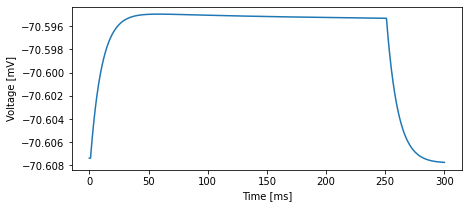

In [8]:
t1 = 1
t2 = 250
T = 300
I0 = 1.3*b2.namp
step_current = input_factory.get_step_current(
    t_start=t1, t_end=t2, unit_time=b2.ms, amplitude=I0
)
state_monitor = adaptive(
    input_current=step_current, 
    simulation_time=T * b2.ms
)
plt.figure(figsize=REC_FIGSIZE)
plt.plot(state_monitor.t/b2.ms, state_monitor.vm[0]/b2.mV, label='Observed voltage curve')
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [mV]')
plt.savefig('2_1-voltage_curve.eps')
plt.show()

## 2.2. Exponential Integrate and Fire

To get an intuiton on how to extract $\theta_{rh}$ and $\Delta_T$, we start by sketching the nonlinear membrane dynamics for different input current:
$$
f(V) = -g_l(V-E_l)+g_l\Delta_Te^{\frac{V-\theta_{rh}}{\Delta_T}} + I_{ext}
$$
As $\Delta_T$ and $\theta_{rh}$ are unknown yet, we use $30mV$ and $-40mV$ respectively.

In [9]:
def f(I, V, gl, El, dT, theta):
    return -gl*(V-El) + gl*dT*math.exp((V-theta)/dT) + I

We must find the external current such that f(V)'s minimum is just above 0. With that current, f(V) is always positive and the membrane voltage will always increase (even if it does very slowly). As it increases, it will necessarily reach the firing voltage and emit a spike. Then, by definition of f(V) as the derivative of the membrane votlage, we can extract $\theta_{rh}$ by identifying the inflexion point of the voltage curve (or, the first maximum of the derivative of the voltage curve).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


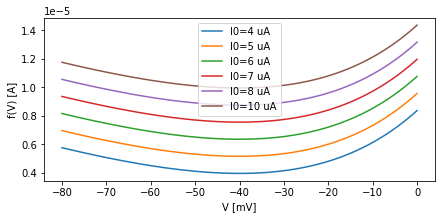

In [10]:
plt.figure(figsize=REC_FIGSIZE)
for I in np.linspace(4,10,6):
    I = I*b2.uamp
    vv = np.linspace(-80, 0, 100)
    ff = [f(I, V*b2.mV, GL, EL, 30*b2.mV, -40*b2.mV) for V in vv]
    plt.plot(vv, ff, label='I0={} uA'.format(int(I*10**6)))
plt.xlabel('V [mV]')
plt.ylabel('f(V) [A]')
plt.legend()
plt.savefig('2_2-f_of_V.eps')
plt.show()

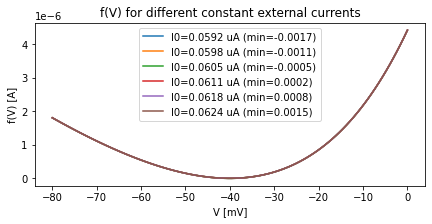

In [11]:
# This is the result of an iterative search (repeating the cell with current bounds around
# the closest values to zero, negative and positive)
plt.figure(figsize=REC_FIGSIZE)
for I in np.linspace(0.0592, 0.0624,6):
    I = I*b2.uamp
    vv = np.linspace(-80, 0, 100)
    ff = [f(I, V*b2.mV, GL, EL, 30*b2.mV, -40*b2.mV) for V in vv]
    min_ = min([f/b2.uA for f in ff])
    plt.plot(vv, ff, label='I0={:.4f} uA (min={:.4f})'.format(I*10**6, min_))
plt.xlabel('V [mV]')
plt.ylabel('f(V) [A]')
plt.title('f(V) for different constant external currents')
plt.legend()
plt.show()

In [12]:
I0 = 0.0611*b2.uamp
I0

61.1 * namp

### Estimate $\theta_{rh}$

Let's record the voltage trace of the HH neuron under a $61.1nA$ current and compute the discrete derivative. $\textbf{NOT WORKING: no spike even with 10 minutes simulation}$

To get a better idea of the required current to estimate the rheobase voltage, we apply the bisection method to find the voltage that just creates a spike with a step current of 3 seconds.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


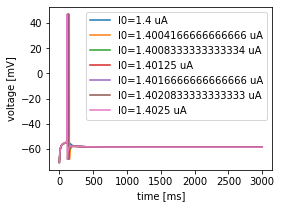

In [13]:
# this is the result of an iterative search (bisection)
plt.figure(figsize=SQ_FIGSIZE)
t1 = 0
t2 = 3*1000
T = t2
for I in np.linspace(1.4, 1.4025, 7):
    curr = input_factory.get_step_current(
        t_start=t1, t_end=t2, unit_time=b2.ms, amplitude=I*b2.uamp
    )
    st_hh = adaptive(
        input_current=curr, simulation_time=T*b2.ms
    )
    plt.plot(st_hh.t/b2.ms, st_hh.vm[0]/b2.mV, label='I0={} uA'.format(I))
plt.xlabel('time [ms]')
plt.ylabel('voltage [mV]')
plt.legend()
plt.savefig('2-2-1_rheobase_current.eps')
plt.show()

Now, we plot f(V) for the found current and the initial guesses for $\Delta_T$ and $\theta_{rh}$ to check that it is actually greater than zero:

In [14]:
I0 = 1.4042 * b2.uamp
I0

1.4042 * uamp

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


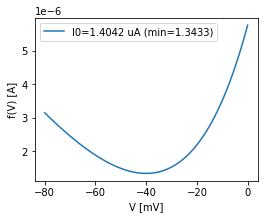

In [15]:
plt.figure(figsize=SQ_FIGSIZE)
vv = np.linspace(-80, 0, 100)
ff = [f(I0, V*b2.mV, GL, EL, 30*b2.mV, -40*b2.mV) for V in vv]
min_ = min([f/b2.uA for f in ff])
plt.plot(vv, ff, label='I0={:.4f} uA (min={:.4f})'.format(I0*10**6, min_))
plt.xlabel('V [mV]')
plt.ylabel('f(V) [A]')
plt.legend()
plt.savefig('2-2-1_rheobase_current_f_of_V.eps')
plt.show()

Now, we are ready to find $\theta_{rh}$ graphically. We saw above that the spike happend after about 200ms, so we simulate for 350ms and compute the derivative.

In [16]:
def discrete_derivative(x, t=None):
    dx = []
    if t is None:
        for i in range(len(x)-1):
            dx.append((x.vm[0][i+1]-x.vm[0][i]) / (x.t[i+1]-x.t[i]) * b2.ms / b2.mV)
        return dx
    else:
        for i in range(len(x)-1):
            dx.append((x[i+1]-x[i]) / (t[i+1]-t[i]))
        return dx

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


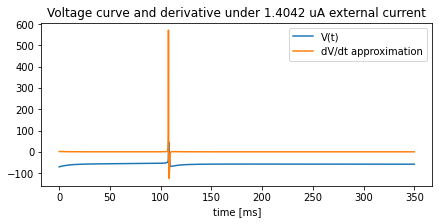

In [17]:
t_start = 0
t_end = 350
T = t_end
plt.figure(figsize=REC_FIGSIZE)
step_current = input_factory.get_step_current(
    t_start=t_start, t_end=t_end, unit_time=b2.ms, amplitude=I0
)
st_hh = adaptive(
    input_current=step_current, simulation_time=T * b2.ms)
ff = list(st_hh.vm[0]/b2.mV)
dfdt = discrete_derivative(st_hh)
plt.plot(st_hh.t / b2.ms, ff, label='V(t)')
plt.plot(st_hh.t[:-1] / b2.ms, dfdt, label='dV/dt approximation')
plt.xlabel('time [ms]')
plt.title('Voltage curve and derivative under {:.4f} uA external current'.format(I0*10**6))
plt.legend()
plt.savefig('2-2-1_voltage_and_derivative_long.eps')
plt.show()

Let's zoom in to the first spike:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


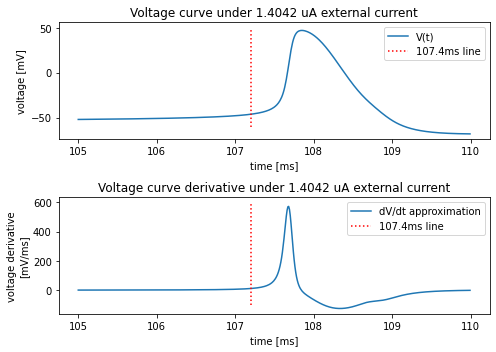

In [18]:
xmin = 10500
xmax = 11000
ts = st_hh.t / b2.ms
_, ax = plt.subplots(nrows=2, ncols=1, figsize=STACK_FIGSIZE)
ax[0].plot(ts[xmin:xmax], ff[xmin:xmax], label='V(t)')
ax[1].plot(ts[xmin:xmax], dfdt[xmin:xmax], label='dV/dt approximation')
ax[1].set_xlabel('time [ms]')
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('voltage [mV]')
ax[1].set_ylabel('voltage derivative\n[mV/ms]')
ax[0].set_title('Voltage curve under {:.4f} uA external current'.format(I0*10**6))
ax[1].set_title('Voltage curve derivative under {:.4f} uA external current'.format(I0*10**6))
plt.tight_layout()
ax[0].vlines(107.2, -60, 50, color='red', linestyle='dotted', label='107.4ms line')
ax[1].vlines(107.2, -100, 600, color='red', linestyle='dotted', label='107.4ms line')
ax[0].legend()
ax[1].legend()
plt.savefig('2-2-1_voltage_and_derivative.eps')
plt.show()

The rheobase voltage $\theta_{rh}$ corresponds to the voltage for after which the neuron starts the firing dynamics, i.e the point at which $V(t)$ starts growing again before the spike. We can extract $\theta_{rh}$ visually from the plots of $V(t)$ and $dV(t)/dt$ by identifying the voltage for which the slope of both curves starts to be significantly larger than in the previous phase. It seems that $107.2ms$ is a good approximation. Therefore $\theta_{rh}\approx V(t=107.2ms)$.

In [19]:
THETA = st_hh.vm[0][int(107.2*100)]

In [20]:
THETA

-46.19720492 * mvolt

Retrieving $\theta_{rh}$ from the maximum of $dV(t)/dt$ gives $\theta_{rh}\approx -46.197 mV$. This result is consistent with the plots. It is greater than the resting potential and smaller than the spike potential (maximum membrane potential).

### Estimate $\Delta_T$

We start by finding the maximum amplitude that doesn't generate a spike under a pulse of $1\mu s$.

In [21]:
t1 = 10
t2 = 11
T = 100

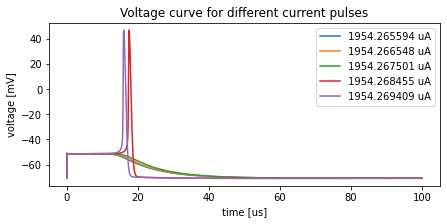

In [22]:
# This is the result of an iterative search, repeating the cell with min current yielding
# a spike and max current not yielding one
plt.figure(figsize=REC_FIGSIZE)
for I0 in np.linspace(1954.265594, 1954.269409, 5):    
    step_current = input_factory.get_step_current(
        t_start=t1, t_end=t2, unit_time=b2.us, amplitude=I0*b2.uA
    )
    st_hh = adaptive(
        input_current=step_current, simulation_time=T * b2.ms)
    ff = list(st_hh.vm[0]/b2.mV)
    plt.plot(st_hh.t / b2.ms, ff, label='{:.6f} uA'.format(I0))
plt.ylabel('voltage [mV]')
plt.xlabel('time [us]')
plt.title('Voltage curve for different current pulses')
plt.legend()
plt.show()

In [23]:
I0*b2.uamp

1.95426941 * mamp

We seem to have reached a 0.001 $\mu A$ precision, let's stop at $I=1.954267501 mA$.

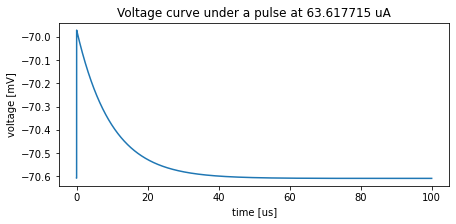

In [24]:
# Find the maximum amplitude that doesnt yield spike
plt.figure(figsize=REC_FIGSIZE)
I0 = 63.617715
step_current = input_factory.get_step_current(
    t_start=t1, t_end=t2, unit_time=b2.us, amplitude=I0*b2.uA
)
st_hh = adaptive(
    input_current=step_current, simulation_time=T * b2.ms)
ff = list(st_hh.vm[0]/b2.mV)
plt.plot(st_hh.t / b2.ms, ff)
plt.ylabel('voltage [mV]')
plt.xlabel('time [us]')
plt.title('Voltage curve under a pulse at {} uA'.format(I0))
plt.show()

In [25]:
Vs = max(st_hh.vm[0])
Vs 

-69.97152239 * mvolt

In [26]:
def f_no_dim(x):
    gl = GL / b2.usiemens
    vs = Vs / b2.mV
    el = EL / b2.mV
    theta = THETA / b2.mV
    return -gl*(vs-el) + gl*x*math.exp((vs-theta)/x)

In [27]:
# Compute zero
DELTAT = fsolve(f_no_dim, x0=7.5)[0]*b2.mV
# Check error
error = f(0*b2.uA, Vs, GL, EL, DELTAT, THETA)
error

-0.55586537 * zamp

In [28]:
DELTAT

8.97921318 * mvolt

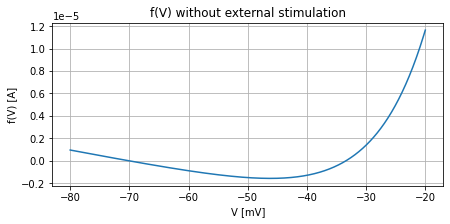

In [29]:
plt.figure(figsize=REC_FIGSIZE)
vv = np.linspace(-80, -20, 1000)
ff = [f(0, V*b2.mV, GL, EL, DELTAT, THETA)  for V in vv]
zeros = np.array(ff)
plt.plot(vv, ff)
plt.xlabel('V [mV]')
plt.ylabel('f(V) [A]')
plt.title('f(V) without external stimulation')
plt.grid()
plt.show()

This curve is inconsistent with the handout. The first zero is approximately at $V_S$ and $E_l$ is not a zero at all. However, $\theta_{rh}$ indeed seems to correspond to the argmin of f(V), at least.

## 2.3 Subthreshold adaptation

Plugging the approiximations in the two ODEs describing the AdEx model:
$$
0 \approx -g_l(V-E_l) + 0 - w + I_{ext} \\
0 \approx a(V-E_l) - w \\
\implies I_{ext} \approx (g_l-a)(V-E_l)
$$
Let's compute $a$ by plotting the I-V curve of a ramp current. In the approximation used above, the relation between I and V is linear. Therefore, we use the slope of I(V) and use it to derive $a$.

In [30]:
ramp_current = input_factory.get_ramp_current(
    t_start=0,
    t_end=10*1000,           # 10s !!
    unit_time=b2.ms,
    amplitude_start=0*b2.uA,
    amplitude_end=1.2*b2.uA
)
st_hh = adaptive(ramp_current, 10*b2.ms)

In [31]:
def create_ramp(x0, x1, dx):
    ramp = []
    x = x0
    N = math.ceil((x1-x0)/dx)
    for n in range(N):
        ramp.append(x+n*dx)
    return ramp
ramp = create_ramp(0,10,ramp_current.dt*10)

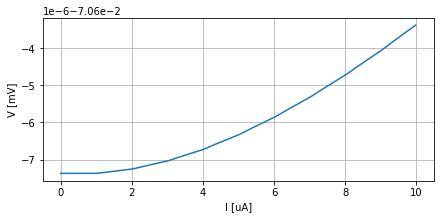

In [32]:
plt.figure(figsize=REC_FIGSIZE)
plt.plot(ramp, st_hh.vm[0], label='V(I)')
plt.xlabel('I [uA]')
plt.ylabel('V [mV]')
# plt.title('I-V curve under a ramp input')
plt.savefig('2-3_IV-curve.eps')
plt.grid()
plt.show()

The linear approximation seems to hold between $5\mu{A}$ and $10\mu{A}$. Let's estimate the slope:

In [33]:
xmin = 5 * 100
xmax = int(9.9 * 100)
vi_slope = (st_hh.vm[0][xmax]-st_hh.vm[0][xmin]) / (ramp[xmax]-ramp[xmin]) /b2.uA
vi_slope

0.59046807 * ohm

The slope of the linear part of $V(I)$ is approximately $m=0.5904k\Omega$. Therefore, ignoring $E_l$ as it does not play a role in the slope:
$$
V \approx mI \implies I \approx \frac{1}{m}V \implies g_l-a \approx \frac{1}{m} \implies a \approx g_l-\frac{1}{m}
$$

In [34]:
A = GL - 1/vi_slope
A

-1.69347089 * siemens

In [35]:
GL

100.77883924 * usiemens

## 2.4. Remaining parameters
Initial guesses: $V_{Reset}=-65mV$, $b=7pA$, $\tau_w=1ms$.

In [36]:
parameters = {
    'tau_m': TAUM,
    'R': R,
    'v_rest': EL,
    'v_reset': -65*b2.mV, ###
    'v_rheobase': THETA,
    'a': A,
    'b': 7*b2.pA, ###
    'v_spike': 30*b2.mV,
    'delta_T': DELTAT,
    'tau_w': 1*b2.ms, ###
    'I_stim': input_factory.get_step_current(
        t_start=0, t_end=1500, unit_time=b2.ms, amplitude=2.*b2.uA
    ),
    'simulation_time': 1500*b2.ms
}
st_hh = adaptive(
    input_current=parameters['I_stim'], simulation_time=parameters['simulation_time']
)

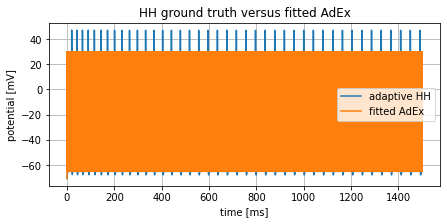

In [37]:
plt.figure(figsize=REC_FIGSIZE)
st_adex, _ = AdEx.simulate_AdEx_neuron(**parameters)
plt.plot((st_hh.t / b2.ms), (st_hh.vm[0] / b2.mV), label='adaptive HH')
plt.plot((st_adex.t / b2.ms), (st_adex.v[0] / b2.mV), label='fitted AdEx')
plt.xlabel('time [ms]')
plt.ylabel('potential [mV]')
plt.title('HH ground truth versus fitted AdEx')
plt.legend()
plt.grid()
plt.show()

First, we can obtain $V_{Reset}$ by finding the minimum of $V(t)$ between the first spike and the second one:

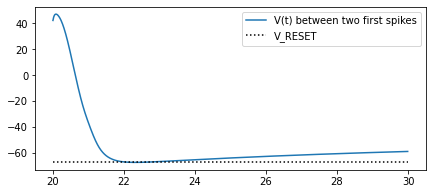

In [38]:
t1 = 20 * 100
t2 = 30 * 100
plt.figure(figsize=REC_FIGSIZE)
plt.plot((st_hh.t / b2.ms)[t1:t2], (st_hh.vm[0] / b2.mV)[t1:t2], label='V(t) between two first spikes')
V_RESET = np.min(st_hh.vm[0][t1:t2])
plt.hlines(V_RESET/b2.mV, 20, 30, color='black', linestyle='dotted', label='V_RESET')
plt.legend()
plt.show()

In [39]:
parameters['v_reset'] = V_RESET
V_RESET

-67.56973247 * mvolt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


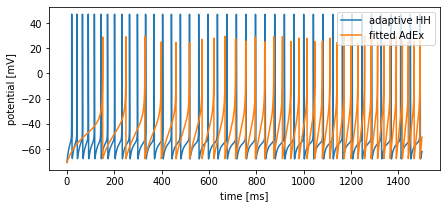

In [40]:
# try different values and evaluate the fit
tau_w =10*1000*1000
b = 10

parameters['tau_w'] = tau_w*b2.ms
parameters['b'] = b*b2.pA
plt.figure(figsize=REC_FIGSIZE)
st_adex, _ = AdEx.simulate_AdEx_neuron(**parameters)
plt.plot((st_hh.t / b2.ms)[0*100:1500*100], (st_hh.vm[0] / b2.mV)[0*100:1500*100], label='adaptive HH')
plt.plot((st_adex.t / b2.ms)[0*100:1500*100], (st_adex.v[0] / b2.mV)[0*100:1500*100], label='fitted AdEx')
plt.xlabel('time [ms]')
plt.ylabel('potential [mV]')
#plt.title('tau_w={}ms, b={}pA'.format(tau_w, b))
plt.legend()
plt.savefig('2-4_final_fit.eps')
plt.show()

In [41]:
parameters

{'tau_m': 37.97148197 * msecond,
 'R': 9.92271798 * kohm,
 'v_rest': -70.6073716 * mvolt,
 'v_reset': -67.56973247 * mvolt,
 'v_rheobase': -46.19720492 * mvolt,
 'a': -1.69347089 * siemens,
 'b': 10. * pamp,
 'v_spike': 30. * mvolt,
 'delta_T': 8.97921318 * mvolt,
 'tau_w': 10. * ksecond,
 'I_stim': <brian2.input.timedarray.TimedArray at 0x7f19d10bf550>,
 'simulation_time': 1.5 * second}

## 2.5 Testing on random input

In [42]:
# function to generate gaussian current
def get_random_gaussian_current(t_start, t_end, unit_time, mean, std, append_zero=True):
    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert b2.units.fundamentalunits.have_same_dimensions(mean, b2.amp), \
        "mean must have the dimension of current. e.g. brian2.uamp" 
    assert b2.units.fundamentalunits.have_same_dimensions(std, b2.amp), \
        "std must have the dimension of current. e.g. brian2.uamp"  
    tmp_size = 1 + t_end  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((tmp_size, 1)) * b2.amp
    if t_end > t_start:  # if deltaT is zero, we return a zero current
        c = mean + std*np.random.randn(t_end-t_start+1, )
        tmp[t_start: t_end + 1, 0] = c
    curr = b2.TimedArray(tmp, dt=1. * unit_time)
    return curr

In [43]:
# stimulate with 500 ms gaussian
gaussian_curr = get_random_gaussian_current(0, 500, b2.ms, 1*b2.uamp, 15*b2.uamp)
parameters['simulation_time'] = 500*b2.ms
parameters['I_stim'] = gaussian_curr
st_hh_500 = adaptive(
    input_current=parameters['I_stim'], simulation_time=parameters['simulation_time']
)
st_adex_500, _ = AdEx.simulate_AdEx_neuron(**parameters)

In [44]:
# stimulate with 2500 ms gaussian
gaussian_curr = get_random_gaussian_current(0, 2500, b2.ms, 1*b2.uamp, 15*b2.uamp)
parameters['simulation_time'] = 2500*b2.ms
parameters['I_stim'] = gaussian_curr
st_hh_2500 = adaptive(
    input_current=parameters['I_stim'], simulation_time=parameters['simulation_time']
)
st_adex_2500, _ = AdEx.simulate_AdEx_neuron(**parameters)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


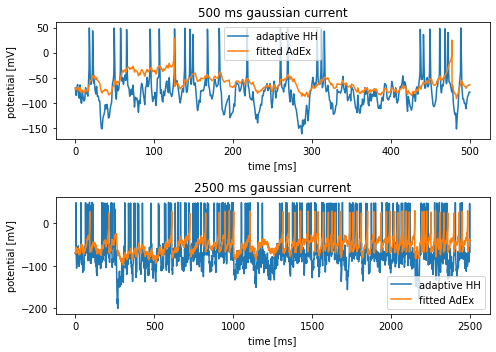

In [45]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=STACK_FIGSIZE)
ax[0].plot((st_hh_500.t / b2.ms), (st_hh_500.vm[0] / b2.mV), label='adaptive HH')
ax[0].plot((st_adex_500.t / b2.ms), (st_adex_500.v[0] / b2.mV), label='fitted AdEx')
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('potential [mV]')
ax[0].set_title('500 ms gaussian current')
ax[1].plot((st_hh_2500.t / b2.ms), (st_hh_2500.vm[0] / b2.mV), label='adaptive HH')
ax[1].plot((st_adex_2500.t / b2.ms), (st_adex_2500.v[0] / b2.mV), label='fitted AdEx')
ax[1].set_xlabel('time [ms]')
ax[1].set_ylabel('potential [mV]')
ax[1].set_title('2500 ms gaussian current')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('2-5_gaussian.eps')
plt.show()